<a href="https://colab.research.google.com/github/Henil21/University-Research/blob/main/ITM_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI Classification using CNN
**Index**

```
1. Fetching data ⛅ 
2. Helper function for visualizing  our data 🆘
3. visualizing the training data distribution 🔎
4. pre processing ⚙
5. Lets step into modeling 🕺
6. Helperfunction for plotting loss curves 📉
7. Adam V/S RMSprop 🤜
```
```
2.0  Brain MRI Classification 🧠
2.1  visualizing  our data 🔍
2.2  pre processing ⚙
```

In [ ]:
!nvidia-smi  -L
# making sure GPU is connected ✅

GPU 0: Tesla T4 (UUID: GPU-29604cb1-1be8-1800-d428-6e0c79fafcb1)


##*1 Getting the data ⛅*

In [ ]:
#fetching the data from cloud
Chest_train='/content/drive/MyDrive/Chest/'
Chest_test='/content/drive/MyDrive/Chest-Test'

##2  *Helper function for Visualizing*🆘

In [1]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir,target_class):
 
   # getting class vise dir link
   target=target_dir+target_class

   # taking 1 random image from a list of all images under a class
   random_img=random.sample(os.listdir(target),1)

   #as we have stored it in list we need to access it through index which is zero
   image=mpimg.imread(target+'/'+random_img[0])

   fig = plt.figure(figsize=(5, 2))  # Set the width and height of the figure

   
   #plotting image
   plt.imshow(image)
   
   plt.axis("off")
   print(f"img shape:{image.shape}")

img shape:(200, 300, 3)


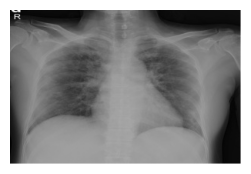

In [ ]:
view_random_image(target_dir=Chest_train,target_class='COVID-19')

## 3 Lets visualize the distribution of the training data 🔍

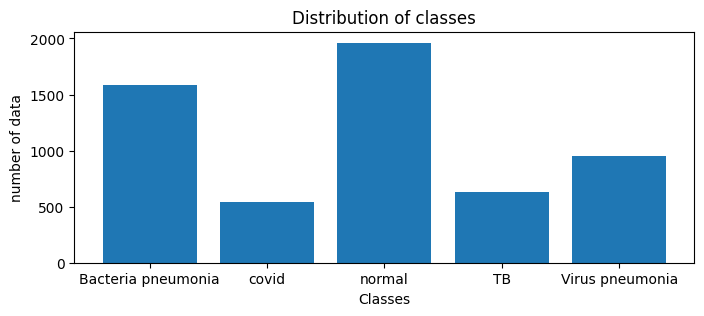

In [ ]:

# getting length of the sub classes
BAC_n=len(os.listdir('/content/drive/MyDrive/Chest/Bacteria pneumonia'))
COVID=len(os.listdir('/content/drive/MyDrive/Chest/COVID-19'))
Normal=len(os.listdir('/content/drive/MyDrive/Chest/NORMAL'))
TB=len(os.listdir('/content/drive/MyDrive/Chest/Tuberculosis'))
virus_n=len(os.listdir('/content/drive/MyDrive/Chest/Virus pneumonia'))

classes=['Bacteria pneumonia', "covid",'normal','TB','Virus pneumonia']
values=[BAC_n,COVID,Normal,TB,virus_n]

fig = plt.figure(figsize=(8, 3))  # Set the width and height of the figure

plt.bar(classes,values)
 
# Adding title to the plot
plt.title("Distribution of classes")
 
# Adding label on the y-axis
plt.ylabel('number of data')
 
# Adding label on the x-axis
plt.xlabel('Classes')

plt.show()

## 4.Pre-processing ⚙

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# recaling pixels 
train_data_gen = ImageDataGenerator(rescale=1./255)

# dividing into batches and  
train_generator = train_data_gen.flow_from_directory(
    Chest_train,
    target_size=(224,224), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)


# recaling pixels 
test_data_gen = ImageDataGenerator(rescale=1./255
                                                              )

# dividing into batches and  
test_generator = train_data_gen.flow_from_directory(
    Chest_test,
    target_size=(224, 224), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)

Found 5669 images belonging to 5 classes.
Found 1395 images belonging to 5 classes.


In [ ]:
import os

# Specify the path to the directory you want to list subdirectories for
directory_path = '/content/drive/MyDrive/Chest-Test'

# Use the os.listdir() function to get a list of all items (files and directories) in the specified directory
items = os.listdir(directory_path)

# Iterate over the items and check if they are directories
subdirectories = []
for item in items:
    item_path = os.path.join(directory_path, item)
    if os.path.isdir(item_path):
        subdirectories.append(item)

# Print the list of subdirectories
print(subdirectories)


['Tuberculosis', 'COVID-19', 'NORMAL', 'Bacteria pneumonia', 'Virus pneumonia']


> we got 5669 images divided into 5 sub-classes for training 

> 1395 images divided into 5 sub-classes for testing

> total image [training+test]= 7064

run below cell if u wanna see numeric representation

In [ ]:
train_generator[0]

(array([[[[0.00392157, 0.00392157, 0.00392157],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.0627451 , 0.0627451 , 0.0627451 ],
          [0.05882353, 0.05882353, 0.05882353],
          [0.04313726, 0.04313726, 0.04313726]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.06666667, 0.06666667, 0.06666667],
          [0.05882353, 0.05882353, 0.05882353],
          [0.04313726, 0.04313726, 0.04313726]],
 
         [[0.        , 0.        , 0.        ],
          [0.00392157, 0.00392157, 0.00392157],
          [0.        , 0.        , 0.        ],
          ...,
          [0.06666667, 0.06666667, 0.06666667],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          [0.04313726, 0.04313726, 0.04313726]],
 
         ...,
 
         [[0.01176471, 0.01176471, 0.01176471],
          [0.01960

## **5. Lets step into modeling 🕺**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import Sequential


tf.random.set_seed(42) #why 42? because it is Answer to the Ultimate Question of Life, the Universe, and Everything if you know you know 

Model_1=Sequential([
    Conv2D(32,3,activation='relu', input_shape=(224,224,3)),  #3 is kernal size 
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(5, activation='softmax') # softmax as we are working with multiclass problem
])


In [ ]:
Model_1.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=tf.keras.optimizers.RMSprop(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp 
                            metrics=['accuracy'])# evaluation 


In [ ]:
history=Model_1.fit(train_generator, 
                   epochs=10,
                    steps_per_epoch=len(train_generator ), 
                   validation_data=(test_generator),
                   validation_steps=len(test_generator ))

Epoch 1/10
178/178 [==============================] - 1428s 8s/step - loss: 0.9884 - accuracy: 0.6029 - val_loss: 0.6440 - val_accuracy: 0.7441
Epoch 2/10
178/178 [==============================] - 25s 141ms/step - loss: 0.6625 - accuracy: 0.7439 - val_loss: 0.4746 - val_accuracy: 0.8079
Epoch 3/10
178/178 [==============================] - 25s 140ms/step - loss: 0.5472 - accuracy: 0.7929 - val_loss: 0.4863 - val_accuracy: 0.7971
Epoch 4/10
178/178 [==============================] - 25s 139ms/step - loss: 0.4847 - accuracy: 0.8093 - val_loss: 0.6201 - val_accuracy: 0.7527
Epoch 5/10
178/178 [==============================] - 24s 137ms/step - loss: 0.4388 - accuracy: 0.8314 - val_loss: 0.5042 - val_accuracy: 0.7878
Epoch 6/10
178/178 [==============================] - 24s 137ms/step - loss: 0.3941 - accuracy: 0.8476 - val_loss: 0.4052 - val_accuracy: 0.8337
Epoch 7/10
178/178 [==============================] - 25s 141ms/step - loss: 0.3632 - accuracy: 0.8566 - val_loss: 0.4787 - val_acc

> accuracy with RMSprop() us 83% for 10 epoch lets check adam()

## 6.helperfunction for plotting loss curves 📉

In [10]:
import pandas as pd
def plot_loss_curves(hist):
    pd.DataFrame(hist.history).plot(figsize=(5,5))

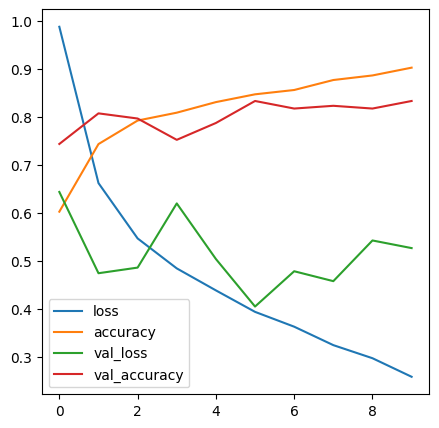

In [ ]:
plot_loss_curves(history)

## 7.Adam V/S RMSprop 🤜

In [ ]:
tf.random.set_seed(42)

Model_2=Sequential([
    Conv2D(32,3,activation='relu', input_shape=(224,224,3)),  #3 is kernal size 
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(5, activation='softmax') # softmax as we are working with multiclass problem
])
Model_2.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=tf.keras.optimizers.Adam(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp 
                            metrics=['accuracy'])# evaluation 

history_2=Model_2.fit(train_generator, 
                   epochs=10,
                    steps_per_epoch=len(train_generator ), 
                   validation_data=(test_generator),
                   validation_steps=len(test_generator ))

Epoch 1/10
178/178 [==============================] - 28s 144ms/step - loss: 0.9588 - accuracy: 0.6065 - val_loss: 0.6427 - val_accuracy: 0.7692
Epoch 2/10
178/178 [==============================] - 25s 139ms/step - loss: 0.6296 - accuracy: 0.7608 - val_loss: 0.6517 - val_accuracy: 0.7247
Epoch 3/10
178/178 [==============================] - 25s 140ms/step - loss: 0.5242 - accuracy: 0.7982 - val_loss: 0.4429 - val_accuracy: 0.8129
Epoch 4/10
178/178 [==============================] - 25s 143ms/step - loss: 0.4570 - accuracy: 0.8218 - val_loss: 0.4297 - val_accuracy: 0.8100
Epoch 5/10
178/178 [==============================] - 65s 366ms/step - loss: 0.4015 - accuracy: 0.8481 - val_loss: 0.3745 - val_accuracy: 0.8373
Epoch 6/10
178/178 [==============================] - 24s 136ms/step - loss: 0.3692 - accuracy: 0.8532 - val_loss: 0.5286 - val_accuracy: 0.8000
Epoch 7/10
178/178 [==============================] - 25s 139ms/step - loss: 0.3310 - accuracy: 0.8723 - val_loss: 0.3605 - val_ac

>  we are getting 86% accuracy with adam with same model architecture 

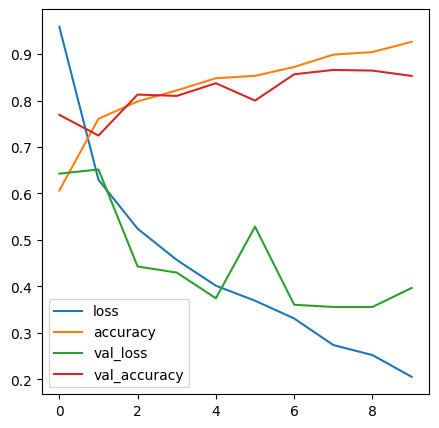

In [ ]:
plot_loss_curves(history_2)

#2.0  Brain MRI Classification 🧠

In [2]:
Brain_train='/content/drive/MyDrive/Brain_multiclass/Training/'
Brain_test='/content/drive/MyDrive/Brain_multiclass/Testing/'

## 2.1 visualizing  our data **🔍**

img shape:(236, 213, 3)


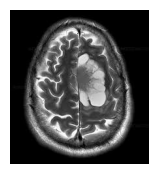

In [3]:
view_random_image(target_dir=Brain_train,target_class='meningioma')

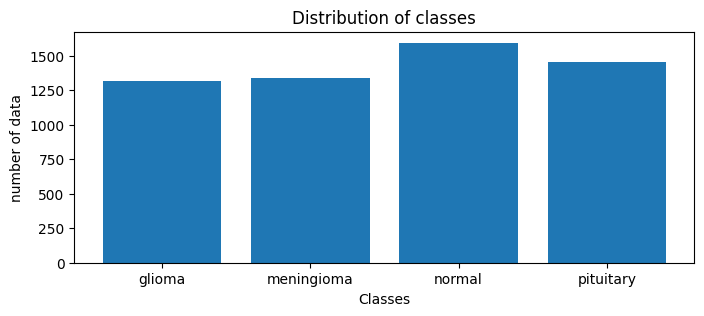

In [4]:

# getting length of the sub classes
gol=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/glioma'))
men=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/meningioma'))
Normal=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/notumor'))
pit=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/pituitary'))

classes=['glioma', "meningioma",'normal','pituitary']
values=[gol,men,Normal,pit]

fig = plt.figure(figsize=(8, 3))  # Set the width and height of the figure

plt.bar(classes,values)
 
# Adding title to the plot
plt.title("Distribution of classes")
 
# Adding label on the y-axis
plt.ylabel('number of data')
 
# Adding label on the x-axis
plt.xlabel('Classes')

plt.show()

## 2.2 Pre-processing ⚙

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# recaling pixels 
train_data_gen = ImageDataGenerator(rescale=1./255)

# dividing into batches and  
train_generator_brain = train_data_gen.flow_from_directory(
    Brain_train,
    target_size=(224, 224), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)


# recaling pixels 
test_data_gen_brain = ImageDataGenerator(rescale=1./255)

# dividing into batches and  
test_generator_brain = train_data_gen.flow_from_directory(
    Brain_test,
    target_size=(224, 224), #targeted shape
    batch_size=32, #32  images per batch
    class_mode='categorical' # we are working with multiclass problem
)

Found 5712 images belonging to 4 classes.
Found 1316 images belonging to 4 classes.


In [ ]:
# train_generator[0] 


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import Sequential
tf.random.set_seed(42)

Model_2=Sequential([
    Conv2D(32,3,activation='relu', input_shape=(224,224,3)),  #3 is kernal size 
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(4, activation='softmax') # softmax as we are working with multiclass problem
])
Model_2.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=tf.keras.optimizers.Adam(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp 
                            metrics=['accuracy'])# evaluation 

history_2=Model_2.fit(train_generator_brain, 
                   epochs=10,
                    steps_per_epoch=len(# dividing into batches and  
                  train_generator_brain  ), 
                   validation_data=(test_generator_brain),
                   validation_steps=len(test_generator_brain ))

Epoch 1/10
179/179 [==============================] - 1891s 11s/step - loss: 0.7211 - accuracy: 0.7059 - val_loss: 0.5481 - val_accuracy: 0.7956
Epoch 2/10
179/179 [==============================] - 37s 207ms/step - loss: 0.3518 - accuracy: 0.8706 - val_loss: 0.3983 - val_accuracy: 0.8397
Epoch 3/10
179/179 [==============================] - 32s 177ms/step - loss: 0.2116 - accuracy: 0.9273 - val_loss: 0.2841 - val_accuracy: 0.8951
Epoch 4/10
179/179 [==============================] - 33s 185ms/step - loss: 0.1392 - accuracy: 0.9568 - val_loss: 0.2294 - val_accuracy: 0.9263
Epoch 5/10
179/179 [==============================] - 32s 176ms/step - loss: 0.0717 - accuracy: 0.9774 - val_loss: 0.2630 - val_accuracy: 0.9096
Epoch 6/10
179/179 [==============================] - 32s 180ms/step - loss: 0.0651 - accuracy: 0.9783 - val_loss: 0.2326 - val_accuracy: 0.9255
Epoch 7/10
179/179 [==============================] - 34s 189ms/step - loss: 0.0350 - accuracy: 0.9907 - val_loss: 0.2159 - val_ac

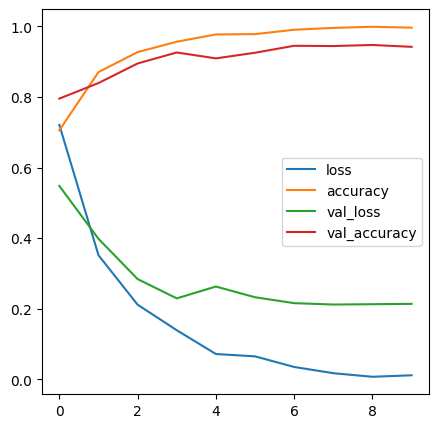

In [11]:
plot_loss_curves(history_2)